In [151]:
pip install numpy pandas seaborn matplotlib plotly nltk scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Importing and Loading Libraries

In [152]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import warnings
import re
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the data

In [153]:
zomato_data=pd.read_csv("zomato.csv", encoding='utf-8')
zomato_df=zomato_data.copy()
zomato_df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


# Data Preparation/Cleaning

In [154]:
#Dropping the column "dish_liked", "phone", "url"
zomato_df=zomato_df.drop(['phone','dish_liked','menu_item'],axis=1)
#Remove the NaN values from the dataset
zomato_df.dropna(how='any',inplace=True)
#Removing the Duplicates
zomato_df.duplicated().sum()
zomato_df.drop_duplicates(inplace=True)
#Changing the column names
zomato_df = zomato_df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})
#Removing '/5' from Rates
zomato_df = zomato_df.loc[zomato_df.rate !='NEW']
zomato_df = zomato_df.loc[zomato_df.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == str else x
zomato_df.rate = zomato_df.rate.apply(remove_slash).str.strip().astype('float')
#Changing the cost to string
zomato_df['cost'] = zomato_df['cost'].astype(str) 
zomato_df['cost'] = zomato_df['cost'].apply(lambda x: x.replace(',','.'))
zomato_df['cost'] = zomato_df['cost'].astype(float)

In [155]:
zomato_df.shape

(41263, 14)

# Data Transformation

In [156]:
## Computing Mean Rating
restaurants = list(zomato_df['name'].unique())
zomato_df['Mean Rating'] = 0
for i in range(len(restaurants)):
    zomato_df['Mean Rating'][zomato_df['name'] == restaurants[i]] = zomato_df['rate'][zomato_df['name'] == restaurants[i]].mean()   
#Scaling the mean rating values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
zomato_df[['Mean Rating']] = scaler.fit_transform(zomato_df[['Mean Rating']]).round(2)

In [157]:
zomato_df[['name', 'rate', 'Mean Rating']].head()

,name,rate,Mean Rating
0,Jalsa,4.1,3.99
1,Spice Elephant,4.1,3.97
2,San Churro Cafe,3.8,3.58
3,Addhuri Udupi Bhojana,3.7,3.45
4,Grand Village,3.8,3.58


# Text Preprocessing and Cleaning

In [158]:
## Lower Casing
zomato_df["reviews_list"] = zomato_df["reviews_list"].str.lower()
## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_punctuation(text))
# Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_stopwords(text))
#Cleaning URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_urls(text))

In [159]:
zomato_df[['reviews_list', 'cuisines']][:5]

,reviews_list,cuisines
0,rated 40 ratedn beautiful place dine inthe int...,"North Indian, Mughlai, Chinese"
1,rated 40 ratedn dinner family turned good choo...,"Chinese, North Indian, Thai"
2,rated 30 ratedn ambience good enough pocket fr...,"Cafe, Mexican, Italian"
3,rated 40 ratedn great food proper karnataka st...,"South Indian, North Indian"
4,rated 40 ratedn good restaurant neighbourhood ...,"North Indian, Rajasthani"


# Exploratory Data Analysis

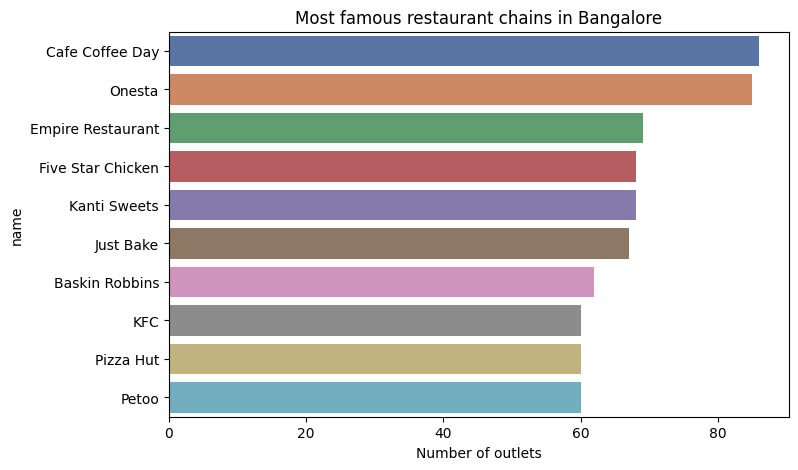

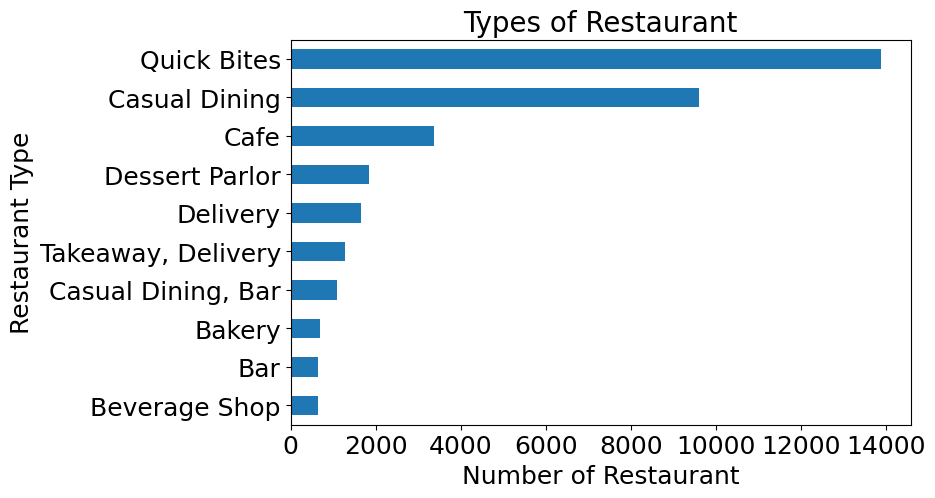

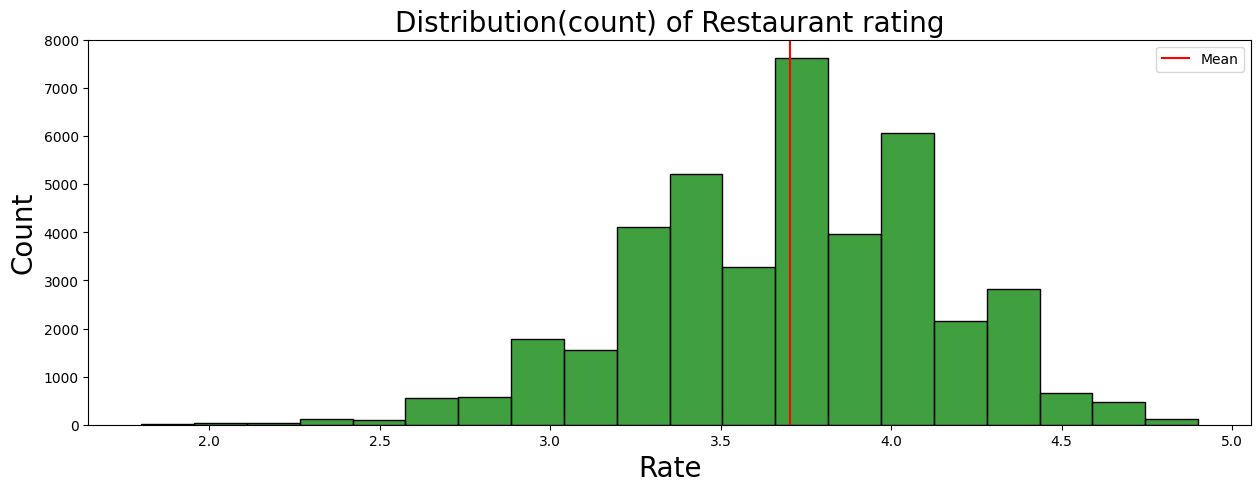

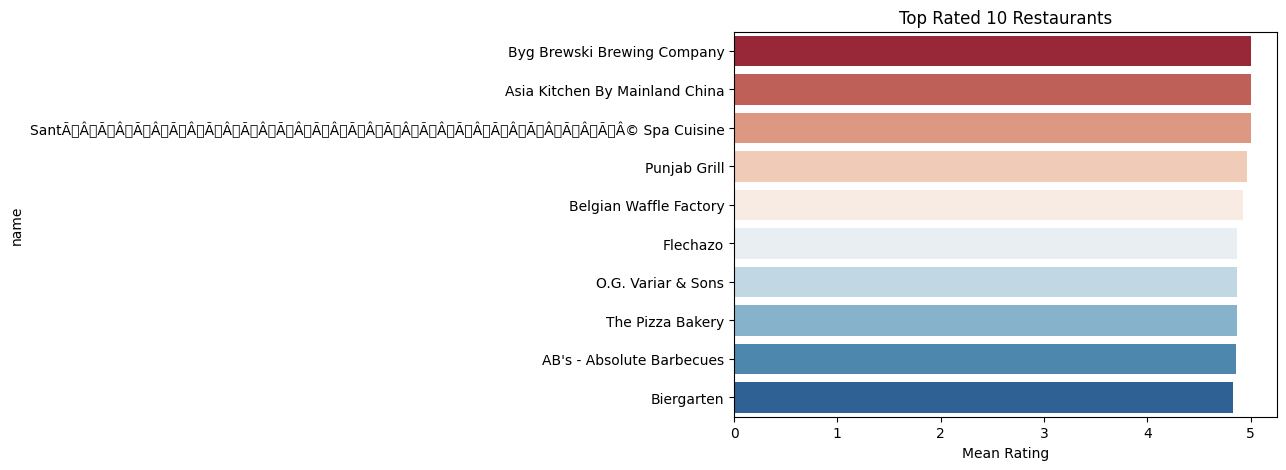

In [160]:
# Most Famous restaurant chains in Bangalore
plt.figure(figsize=(8,5))
chains = zomato_df['name'].value_counts()[:10]
sns.barplot(x=chains, y=chains.index, palette='deep')
plt.title("Most famous restaurant chains in Bangalore")
plt.xlabel("Number of outlets")
plt.show()  # Make sure the plot displays

# Types of Restaurant
counts = zomato_df["rest_type"].value_counts()[:10]
p = counts.sort_values().plot.barh(figsize=(8,5), fontsize=18)
p.set_xlabel("Number of Restaurant", fontsize=18)
p.set_ylabel("Restaurant Type", fontsize=18)
p.set_title("Types of Restaurant", fontsize=20)
plt.show()  # Make sure the plot displays

# Distribution of Restaurant Rating
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.histplot(zomato_df['rate'], kde=False, color='g', ax=ax, bins=20)  # Use histplot instead of distplot
ax.axvline(zomato_df['rate'].mean(), 0, 1, color='r', label='Mean')
ax.legend()
ax.set_ylabel('Count', size=20)
ax.set_xlabel('Rate', size=20)
ax.set_title('Distribution(count) of Restaurant rating', size=20)
plt.show()  # Make sure the plot displays

# Top 10 Rated Restaurants
df_rating = zomato_df.drop_duplicates(subset='name')
df_rating = df_rating.sort_values(by='Mean Rating', ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(data=df_rating, x='Mean Rating', y='name', palette='RdBu')
plt.title('Top Rated 10 Restaurants')
plt.show()  # Make sure the plot displays

# EDA- Word Frequency Distribution

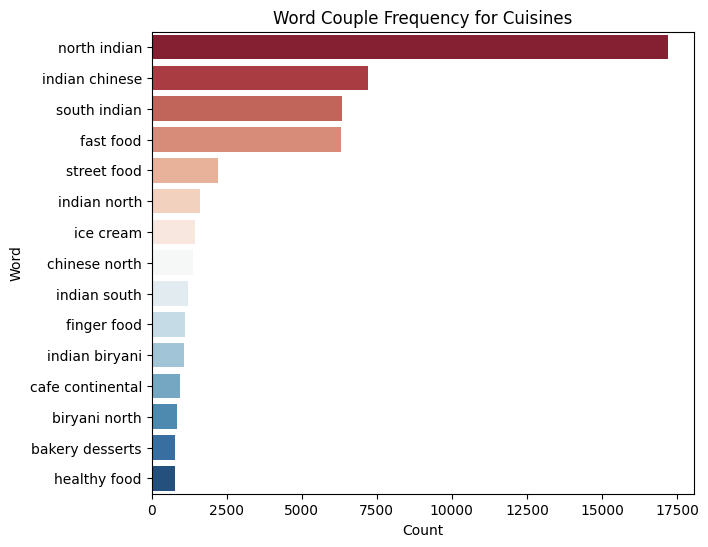

In [168]:
def get_top_words(column, top_nu_of_words, nu_of_word):
    vec = CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

# Top 15 two word frequencies for Cuisines
lst = get_top_words(zomato_df['cuisines'], 15, (2, 2))
df_words = pd.DataFrame(lst, columns=['Word', 'Count'])

# Now we properly separate the plotting code
plt.figure(figsize=(7, 6))
sns.barplot(data=df_words, x='Count', y='Word', palette='RdBu')
plt.title('Word Couple Frequency for Cuisines')
plt.show()

# CONTENT-BASE RECOMMENDER SYSTEM

In [162]:
zomato_df = zomato_df.drop(['address', 'rest_type', 'type', 'votes'], axis=1)

df_percent = zomato_df.sample(frac=0.5)
df_percent.set_index('name', inplace=True)
indices = pd.Series(df_percent.index)

df_percent.shape

(20632, 10)

In [163]:
# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['reviews_list'])

In [164]:
# Calculating Cosine Similarity
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Making a Recommendation

In [165]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['name', 'cuisines', 'Mean Rating', 'cost'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        temp_df = df_percent[['cuisines', 'Mean Rating', 'cost']][df_percent.index == each].sample()
        temp_df['name'] = each  
        
        df_new = pd.concat([df_new, temp_df], ignore_index=True)
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['name', 'cuisines', 'Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)
    df_new = df_new.reset_index(drop=True)
    
    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))
    
    return df_new

# RESULTS

In [166]:
check_restaurant = 'Marwa Restaurant'
zomato_df.loc[(zomato_df.name == check_restaurant)][:1]

,url,name,online_order,book_table,rate,location,cuisines,cost,reviews_list,city,Mean Rating
931,https://www.zomato.com/bangalore/marwa-restaur...,Marwa Restaurant,Yes,Yes,3.5,Bannerghatta Road,"North Indian, Chinese, Fast Food, BBQ",600.0,rated 50 ratedn disappointed decision shifting...,Bannerghatta Road,3.19


In [167]:
recommend(check_restaurant)

TOP 10 RESTAURANTS LIKE Marwa Restaurant WITH SIMILAR REVIEWS: 


,name,cuisines,Mean Rating,cost
0,Aramane Donne Biriyani,"Biryani, Fast Food",3.71,300.0
1,Al Sadique,"North Indian, Mughlai, Chinese, Rolls",3.71,450.0
2,Cinnamon,"North Indian, Asian, Continental",3.62,1.0
3,Cinnamon,"North Indian, Chinese, Biryani",3.62,550.0
4,Altaf's Chillies Restaurant,"North Indian, Chinese",3.61,500.0
5,Raichur Biryani House,"Biryani, North Indian, Chinese",3.58,400.0
6,Magix's Parattha Roll,"Fast Food, North Indian, Chinese, Mughlai, Rolls",3.52,400.0
7,Sri Sai Mango Tree Restaurant,"North Indian, Biryani, Chinese",3.32,600.0
8,The Diner,"North Indian, Chinese, Andhra, Biryani",3.32,700.0
9,Red Chilliez,"North Indian, Chinese, Seafood, Mangalorean",3.26,650.0
